# Problem 3

This challenge's goal is to cluster a genetic expression dataset to find out which individuals belong to the same family.

The available dataset contains read counts on 65215 genes for 48 individuals. Read counts are simply the number of reads overlapping a given feature such as a gene.

The steps are listed bellow:

1. Preprocessing

    1.1 Dimension Reduction
    
2. Modeling

    2.1 Mean Shift
    
    2.2 Affinity Propagation
    
    2.3 K-Means (cotovelo)
    
3. Results

In [1]:
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift
from sklearn.cluster import AffinityPropagation

In [2]:
raw_df = pd.read_excel(
    io='data/readcounts.xlsx',
    sheet_name='Sheet 1',
)
raw_df.rename(
    columns={
        'Unnamed: 0': 'gene',
    },
    inplace=True,
)
raw_df.set_index(['gene'], inplace=True)
raw_df.iloc[:5, :5]

,H223,H224,H225,H226,H227
gene,,,,,
ENSG00000000003,0,0,0,1,0
ENSG00000000005,0,0,0,0,0
ENSG00000000419,1216,1228,1022,912,491
ENSG00000000457,189,114,110,289,186
ENSG00000000460,74,38,55,127,30


In [3]:
df = raw_df.transpose()
df.iloc[:5, :5]

gene,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460
H223,0,0,1216,189,74
H224,0,0,1228,114,38
H225,0,0,1022,110,55
H226,1,0,912,289,127
H227,0,0,491,186,30


## 1. Preprocessing

In this step we want to understand better the dataset. Before the analysis the dataset is transposed so we can work with columns as genes and rows as individuals.

No null values were found in the dataset.

In [4]:
print(f'{df.isnull().sum().sum()} null values in the dataset')

0 null values in the dataset


The features are scaled with MinMaxScaler, which scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [5]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
pd.DataFrame(scaled_df).iloc[:5, :5]

,0,1,2,3,4
0,0.0,0.0,0.986813,0.570815,0.446667
1,0.0,0.0,1.000000,0.248927,0.206667
2,0.0,0.0,0.773626,0.231760,0.320000
3,0.5,0.0,0.652747,1.000000,0.800000
4,0.0,0.0,0.190110,0.557940,0.153333


### 1.1 Dimension Reduction

Then we want to reduce the amount of features that we work. To accomplish this, we use a dimension reduction technique called Principal Component Analysis (PCA).

We calculate the explained variance for a big range, then choose the number of components as the first one to increment less than 1% of explained variance.

In [6]:
explained_variance = []
pca_range = range(1, 49)
for i in pca_range:
    pca = PCA(n_components=i)
    pca.fit(scaled_df)
    explained_variance.append(
        pca.explained_variance_ratio_.sum()
    )

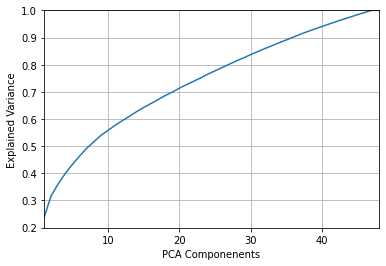

In [7]:
plt.plot(
    pca_range,
    explained_variance,
)
plt.grid()

plt.xlim(1, 48)
plt.ylim(top=1)
plt.xlabel('PCA Componenents')
plt.ylabel('Explained Variance')

plt.show()

In [8]:
increments = pd.Series(explained_variance).diff()
n_components = increments[increments < 0.01].head(1).index[0]
print(f'{n_components} components will be used in PCA'
     )

37 components will be used in PCA


In [9]:
pca = PCA(n_components=n_components)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df))

pca_df['individual'] = df.index.values
pca_df.set_index(['individual'], inplace=True)
pca_df.to_csv('data/preprocessed.csv')

pca_df.iloc[:5, :5]

,0,1,2,3,4
individual,,,,,
H223,18.340243,20.825835,-17.729945,13.418951,-15.678389
H224,12.314263,25.987810,-11.261078,3.046597,-10.571137
H225,8.012761,20.284830,-2.970114,3.415163,-15.405132
H226,34.803789,-15.939258,-19.751026,5.664299,-13.279414
H227,-23.291799,-8.902903,-9.867072,-4.734554,-8.014487


## 2. Modeling

### 2.1 Mean Shift

Mean Shift clustering aims to discover blobs in a smooth density of samples. It is a centroid based algorithm, which works by updating candidates for centroids to be the mean of the points within a given region.

The Mean Shift did not return a good result. 40 individuals where classified as the same family, but other 8 families have only one individual.

In [10]:
meanshift = MeanShift().fit(pca_df)
pd.Series(
    collections.Counter(meanshift.labels_)
).sort_index()

0    40
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
dtype: int64

### 2.2 Affinity Propagation

Affinity Propagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.

This algorithm seems to return a better result than Mean Shift. We can see 4 families with number of individuals varying from 3 to 19, and other 4 individuals that don't belong to these families.

In [11]:
affprop = AffinityPropagation(
    random_state=3
).fit(pca_df)
pd.Series(
    collections.Counter(affprop.labels_)
).sort_index()

0     3
1    15
2     1
3     7
4     1
5     1
6    19
7     1
dtype: int64

## 3. Results

We can se that the best results were given by the Affinity Propagation algorithm. Mean Shift returned only one family and another 8 individuals.

The final results choosen is the Affinity Propagation output, the dataset contains 4 families.

In [12]:
results = pd.DataFrame()

results['individual'] = df.index.values
results['family'] = affprop.labels_

results.to_csv(
    'data/results.csv',
    index=False,
)

## References

1. [CureFFI](https://www.cureffi.org/2013/09/12/counts-vs-fpkms-in-rna-seq/)
2. [Clustering Algorithms](https://scikit-learn.org/stable/modules/clustering.html)
3. [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)